In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import pandas as pd
import time
from functions import plots
from functions import finite_volumes as fv
from functions import finite_volumes_split as fvs
from functions import finite_volumes_par as fvp
from functions import neural_network as nn
import mnist

# IMAGE INPAINTING WITH FLUID DYNAMICS

Image inpainting aims to remove damage from an image. There are various techniques for image inpainting, and here we focus on solving a fluid-type PDE denoted as the Cahn-Hilliard equation.

The three take-home messages from this notebook are that:

1. Image inpainting can be solved with efficient and parallelizable finite-volume schemes
2. The classification accuracy of neural networks is affected by the presence of damage 
3. The application of image inpainting in damaged images improves their classification accuracy

<p>&nbsp;</p>

#### Damaged image:
<img src="images/damage_23.png" style="width:300px;height:250px;" >

#### Restored image:
<img src="images/inpainting_23.png" style="width:300px;height:250px;" >

As an example we take the MNIST dataset, which consists of binary images of handwritten digits:

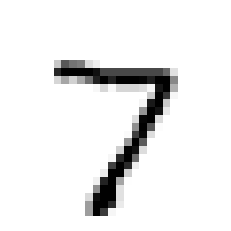

In [4]:
test_images = mnist.test_images() # Load MNIST test set
test_images = test_images.reshape((-1,784)) # Flatten
test_images = (test_images / 255) *2-1 # Normalize between -1 and 1
example = test_images[0,:] # Select 1 image
plots.plot_image(example) # Plot image

The MNIST dataset is corrupted by adding different types of damage to it:

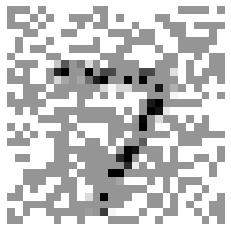

In [5]:
intensity = 0.5 # elect % of damaged pixels

damage = np.random.choice(np.arange(example.size), replace=False, 
                          size=int(example.size * intensity)) # Create random damage
damaged_example = example.copy() # Generate damaged example
damaged_example[damage] = 0 # Turn damaged pixels to 0
plots.plot_image(damaged_example) # Plot image

## Finite volumes for image inpainting

With image inpainting we aim to recover the original image. There are various methods to conduct image inpainting, and here I solve a modified Cahn-Hilliard equation via finite-volume schemes:


$$
\frac{\partial \phi (x,t)}{\partial t}= -\nabla^{2} \left(\epsilon^2 \nabla^{2} \phi -  H'(\phi) \right) + \lambda(x)\left(\phi (x,t=0) - \phi\right)
$$

As a baseline let's solve this equation with a simple finite-volume scheme:

--------------------
Time:  0.0
['L1 norm of the difference between the new and old state: ', 287.3386803062433]
--------------------
Time:  0.1
['L1 norm of the difference between the new and old state: ', 67.94696179284345]
--------------------
Time:  0.2
['L1 norm of the difference between the new and old state: ', 28.44534121387825]
--------------------
Time:  0.30000000000000004
['L1 norm of the difference between the new and old state: ', 11.891385877497221]
--------------------
Time:  0.4
['L1 norm of the difference between the new and old state: ', 6.234427214932593]
--------------------
Time:  0.5
['L1 norm of the difference between the new and old state: ', 3.2354780776968823]
--------------------
Time:  0.6
['L1 norm of the difference between the new and old state: ', 1.88598721436359]
--------------------
Time:  0.7
['L1 norm of the difference between the new and old state: ', 1.1229330707104483]
--------------------
Time:  0.7999999999999999
['L1 norm of the difference bet

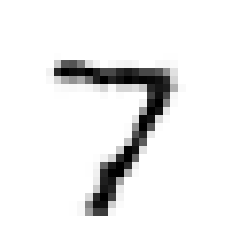

In [6]:
start = time.time() # Start time
restored_example = fv.temporal_loop(damaged_example, damage) # Run finite-volume scheme
print("Total time: {:.2f}".format(time.time()-start)) # Print spent time
plots.plot_image(restored_example) # Plot image

In [8]:
damage

array([620, 398, 499, 238, 326, 737,  99, 577, 217, 365, 605, 313, 340,
       438,  11, 544, 660, 317, 130, 693, 322, 428, 583, 375, 449, 728,
       199, 590,  24, 771, 209, 210, 455, 542, 550, 658, 769, 539, 276,
       498, 372, 734, 291, 232, 598, 434, 427, 164, 359, 181, 639,  47,
       687, 370, 472, 168, 377,   1, 756, 664, 413, 318, 489, 652, 257,
       708, 619, 533, 515, 566, 207, 182, 634, 268, 468, 314, 757, 212,
       333, 781, 275, 240, 260, 739, 647, 127, 645, 559,  57, 249, 568,
       754, 661, 279, 705, 514, 155, 513, 704, 445, 719,  68, 117, 523,
       669, 406, 345, 308, 723, 511,  87,  38, 315, 518, 143, 441, 243,
       557, 543, 412, 192, 154, 339, 265,  82, 482, 239, 252,  36, 148,
       651, 516, 548, 163, 244, 736, 522, 266, 353, 144, 624, 586, 401,
       686, 713,  28, 475, 683, 582, 752, 410, 650, 474, 273, 581, 356,
       606, 666, 444,   4, 534, 403,  40, 408, 570, 223, 151, 110, 483,
       204, 749, 162, 189, 404, 442, 525, 593, 136, 748, 286, 65

Let's compare the restored image with respect to the original image:


In [ ]:
plots.plot_3images(example, damaged_example, restored_example)  # Plot 3 images

The computational cost of finite-volume scheme can be reduced by:

1. Applying a dimensional-splitting technique and solving row by row and column by column
2. Parallelizing the code and solving rows/columns simultaneously

The simple finite-volume scheme has taken 40s to run. Let's compare it with the dimensional-splitting code:fully parallelized code:

In [ ]:
start = time.time() # Start time
restored_example = fvs.temporal_loop_split(damaged_example, damage) # Run finite-volume scheme
print("Total time: {:.2f}".format(time.time()-start)) # Print spent time
plots.plot_image(restored_example) # Plot image

By dimensionally splitting the code we have reduced the computational time from 40s to 8s!

Can we reduce that time by parallelizing?

In [ ]:
num_proc = 8 # Number of processors
start = time.time() # Start time
restored_example = fvp.temporal_loop_par(damaged_example, damage, num_proc) # Run finite-volume scheme
print("Total time: {:.2f}".format(time.time()-start)) # Print spent time
plots.plot_image(restored_example) # Plot image

The parallel code takes 15 seconds, which is a higher than the non-parallel one. Parallelizing the code does not reduce that time since MNIST images are only 28x28. However, for high-dimensional images it has a clear benefit.

## Neural network for classification

![title](images/NN.png)

The neural network is trained with the undamaged training dataset. Then we compare its accuracy for the test images with and without damage:

In [ ]:
train_images = mnist.train_images() # Load training set
train_labels = mnist.train_labels() # Load training labels
train_images = (train_images / 255) *2-1 # Normalize between -1 and 1
train_images = train_images.reshape((-1,784)) # Flatten

model, history = nn.training(train_images, train_labels) # Train the neural network
plots.loss_acc_plots(history) # Plot loss and accuracy

test_labels = mnist.test_labels() # Load test labels
print("Validation of undamaged test set:")
test_loss, test_accuracy = model.evaluate(test_images, to_categorical(test_labels), 
                                          verbose=2) # Print test loss and acc

The accuracy for the test dataset is quite high: 97%. This accuracy drops as we include damage in the test images. For instance, with an intensity of 80% the accuracy is 55%. Can we recover the accuracy by firstly applying image inpainting?

## Image inpainting prior to classifying damaged images

Let's select a group of 5 images to add damage:

In [ ]:
n_images = 5 # Number of images
indices_images = range(5) # Select indices
examples = test_images[indices_images,:].copy() # Choose examples from test set

intensity = 0.8 # Damage intensity
# damages = np.zeros((len(indices_images), int(examples.shape[1] * intensity)), dtype=int) # Instantiate damage matrices
# damaged_examples = examples.copy() # Instantiate damaged examples

damages = np.load("data/damages.npy") # Load a previously saved damage matrix

for i in range(len(indices_images)): # Loop over examples t introduce damage
#     damages[i, :] = np.random.choice(np.arange(examples.shape[1]), replace=False, 
#                                      size=int(examples.shape[1] * intensity)) # Choose random damage
    damaged_examples[i, damages[i, :]] = 0 # Turn damaged pixels to 0

plots.plot_image(damaged_examples[1,:]) # Plot one of the damaged examples

We proceed to restore those 5 images:

In [ ]:
restored_examples = np.zeros(examples.shape) # Instantiate restored examples

for i in range(n_images): # Loop over damaged imaged
    restored_examples[i,:] = fvs.temporal_loop_split(
                                damaged_examples[i, :], damages[i, :])

plots.plot_3images(examples[1,:], damaged_examples[1,:], restored_examples[1,:])

We can now compare the ground truth with the predicted labels for the damaged and restore images:

In [ ]:
predictions_damaged = np.argmax(model.predict(damaged_examples), axis=1)  
predictions_restored = np.argmax(model.predict(restored_examples), axis=1)    

print("Ground truth: ", test_labels[indices_images])
print("Damaged images: ", predictions_damaged)
print("Restored images: ", predictions_restored)

## Final remarks

The three take-home messages from this notebook are that:

1. Image inpainting can be solved with efficient and parallelizable finite-volume schemes
2. The classification accuracy of neural networks is affected by the presence of damage 
3. The application of image inpainting in damaged images improves their classification accuracy